In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [60]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

# Feature Engineering

In [61]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBath'] = (
    df['FullBath'] + 0.5 * df['HalfBath'] +
    df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
)
df['TotalPorchSF'] = (
    df['OpenPorchSF'] + df['EnclosedPorch'] +
    df['3SsnPorch'] + df['ScreenPorch']
)
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

# Cleaning

In [62]:
none_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
             'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
             'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']

for col in none_cols:
    df[col] = df[col].fillna("None")

zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea']

for col in zero_cols:
    df[col] = df[col].fillna(0)

df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

# Training

In [63]:
import mlflow
import mlflow.sklearn

with mlflow.start_run():
    redundant_cols = [
        '1stFlrSF', '2ndFlrSF', 'GarageArea', 'TotRmsAbvGrd',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'PoolArea'
    ]
    X = df.drop(['Id', 'SalePrice'] + redundant_cols, axis=1)
    y = df['SalePrice']

    X = pd.get_dummies(X)

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = Ridge(alpha=10.0)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    preds = np.maximum(preds, 0)

    rmse = np.sqrt(mean_squared_error(y_val, preds))

    mlflow.sklearn.log_model(model, "ridge-model")
    mlflow.log_metric("rmse", rmse)

    print(f"RMSE: {rmse:.2f}")

RMSE: 28131.63


# Visualisation

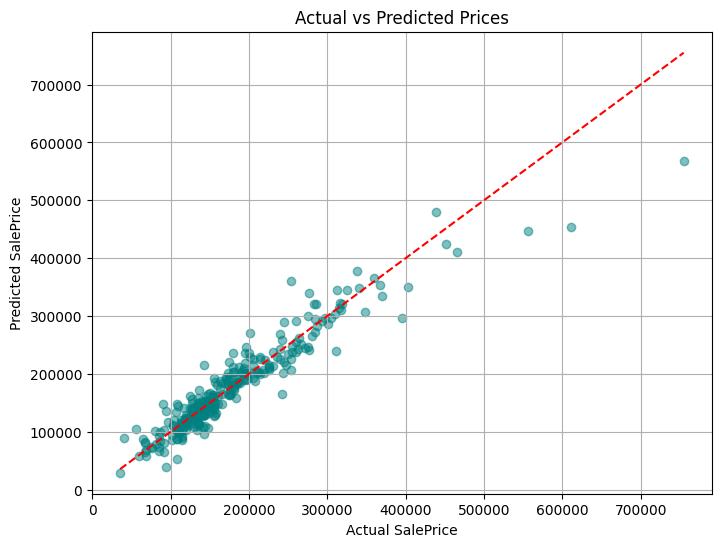

In [64]:
import matplotlib.pyplot as plt

preds = model.predict(X_val)

plt.figure(figsize=(8,6))
plt.scatter(y_val, preds, alpha=0.5, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

In [65]:
import dagshub
dagshub.init(repo_owner='gioeba', repo_name='AdvancedRegressionTechniques', mlflow=True)

mlflow.set_tracking_uri("https://dagshub.com/gioeba/AdvancedRegressionTechniques.mlflow")
mlflow.set_experiment("ridge-model-with-extra-features")
mlflow.set_registry_uri("https://dagshub.com/gioeba/AdvancedRegressionTechniques.mlflow")